## Загрузка библиотек и работа с данными

In [ ]:
import pandas as pd
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# в файлах нет названий колонок, поэтому задаём их сами
train = pd.read_csv('/content/drive/MyDrive/twitter_sent/twitter_training.csv', names=['id', 'topic', 'sentiment', 'tweet'])
test = pd.read_csv('/content/drive/MyDrive/twitter_sent/twitter_validation.csv', names=['id', 'topic', 'sentiment', 'tweet'])

In [ ]:
# на всякий случай удалим строки с пустыми ячейками, если они есть
train = train.dropna()
test = test.dropna()

Для удобства мы сначала поработаем с бинарной классификацией: оставим только полярно противоположные классы Positive и Negative.

In [ ]:
# оператор "|" - это "or"
train_binary = train.loc[(train['sentiment'] == 'Positive') | (train['sentiment'] == 'Negative')]

In [ ]:
test_binary = test.loc[(test['sentiment'] == 'Positive') | (test['sentiment'] == 'Negative')]

### Кодирование зависимой переменной

In [ ]:
le = LabelEncoder()

In [ ]:
le.fit(train_binary['sentiment'])

LabelEncoder()

In [ ]:
le.classes_

array(['Negative', 'Positive'], dtype=object)

In [ ]:
# для кодирования применяется метод transform, опять же, по аналогии с моделями
y_train_binary = le.transform(train_binary['sentiment'])
y_test_binary = le.transform(test_binary['sentiment'])

### Кодирование твитов

In [ ]:
tf_idf = TfidfVectorizer()

In [ ]:
tf_idf.fit(train_binary['tweet'])

TfidfVectorizer()

In [ ]:
X_train_binary = tf_idf.transform(train_binary['tweet'])
X_test_binary = tf_idf.transform(test_binary['tweet'])

In [ ]:
len(y_train_binary)

43013

## Классификация

### Multinomial NB

Начнем с наивного байесовского классификатора. Мы выберем MultinomialNB, потому что он лучше подходит для текстовых признаков.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
nb = MultinomialNB()

In [ ]:
nb.fit(X_train_binary, y_train_binary)

MultinomialNB()

In [ ]:
y_test_pred_nb = nb.predict(X_test_binary)

In [ ]:
print(classification_report(y_test_binary, y_test_pred_nb, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94       266
    Positive       0.96      0.93      0.94       277

    accuracy                           0.94       543
   macro avg       0.94      0.94      0.94       543
weighted avg       0.94      0.94      0.94       543



Неплохо!

### Logreg

Сравним наивный байес с логистической регрессией.

In [ ]:
from sklearn.linear_model import LogisticRegression

#### **Веса классов**

На этом моменте мы можем уравновесить классы. Попробуем это сделать уже сейчас, хотя пока что наши классы достаточно сбалансированы.

Не в каждый объект классификатора можно передать веса классов (например, в MultinomialNB параметра class_weight нет), но с логистической регрессией это сделать можно.

Веса можно или посчитать самим:

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
our_class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train_binary), y=y_train_binary)

In [ ]:
np.unique(y_train_binary)

array([0, 1])

In [ ]:
our_class_weights

array([0.9619152 , 1.04122489])

In [ ]:
# теперь, чтобы передать веса в классификатор, нам надо сделать словарь, где ключи - лейблы классов, а значения - веса
class_weights_dict = {k: v for k, v in enumerate(our_class_weights)}

In [ ]:
class_weights_dict

{0: 0.9619151981393684, 1: 1.0412248850157346}

In [ ]:
classifier = LogisticRegression(random_state=42, class_weight=class_weights_dict)

Или можно просто передать class_weight='balanced' сразу в классификатор, ничего не считая. Это намного удобнее:

In [ ]:
classifier = LogisticRegression(random_state=42, class_weight='balanced')

In [ ]:
classifier.fit(X_train_binary, y_train_binary)

LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
y_test_pred_binary = classifier.predict(X_test_binary)

In [ ]:
print(classification_report(y_test_binary, y_test_pred_binary, target_names=le.classes_))

              precision    recall  f1-score   support

    Negative       0.95      0.94      0.95       266
    Positive       0.95      0.95      0.95       277

    accuracy                           0.95       543
   macro avg       0.95      0.95      0.95       543
weighted avg       0.95      0.95      0.95       543



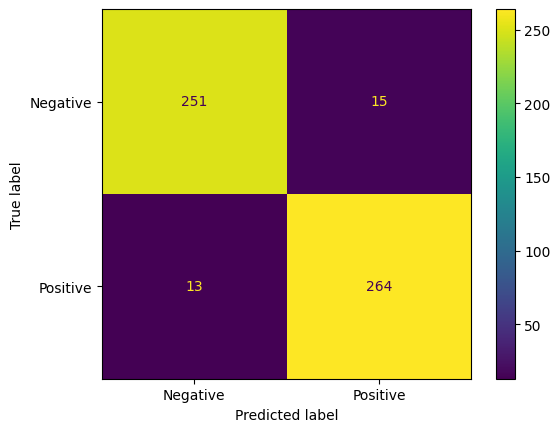

In [ ]:
cm = confusion_matrix(y_test_binary, y_test_pred_binary)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot()

### Кривая ошибок

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

Мы знаем, что для кривой ошибок нужны оси чувствительности (tpr) и специфичности (fpr). Их можно получить с помощью метода roc_curve. Для этого нам понадобятся не предсказания модели, а их вероятности.

In [ ]:
predicted_probs = classifier.predict_proba(X_test_binary)

In [ ]:
predicted_probs

array([[0.86722119, 0.13277881],
       [0.85926034, 0.14073966],
       [0.94122889, 0.05877111],
       ...,
       [0.07977306, 0.92022694],
       [0.07742466, 0.92257534],
       [0.1370569 , 0.8629431 ]])

Если посмотреть в документацию: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html, можно увидеть, что для построения кривой в параметр y_score нужно передать probability estimates of the positive class, т.е. вероятности класса 1. Так что нам нужна только одна колонка из predicted_probs.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_binary, predicted_probs[:,1])
roc_auc = auc(fpr, tpr)

In [ ]:
len(thresholds)

46

In [ ]:
len(y_test_binary)

543

In [ ]:
fpr

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.0037594 , 0.0037594 , 0.0075188 , 0.0075188 , 0.0112782 ,
       0.0112782 , 0.01879699, 0.01879699, 0.02631579, 0.02631579,
       0.03383459, 0.03383459, 0.03759398, 0.03759398, 0.04511278,
       0.04511278, 0.05263158, 0.05263158, 0.05639098, 0.05639098,
       0.06015038, 0.06015038, 0.09398496, 0.09398496, 0.10150376,
       0.10150376, 0.12030075, 0.12030075, 0.13533835, 0.13533835,
       0.15037594, 0.15037594, 0.19172932, 0.19172932, 0.42481203,
       0.42481203, 0.72556391, 0.72556391, 0.88721805, 0.89473684,
       1.        ])

In [ ]:
tpr

array([0.        , 0.00361011, 0.07942238, 0.09025271, 0.68953069,
       0.68953069, 0.71480144, 0.71480144, 0.76173285, 0.76173285,
       0.89169675, 0.89169675, 0.90613718, 0.90613718, 0.93140794,
       0.93140794, 0.93501805, 0.93501805, 0.94223827, 0.94223827,
       0.94945848, 0.94945848, 0.95306859, 0.95306859, 0.96028881,
       0.96028881, 0.97111913, 0.97111913, 0.97472924, 0.97472924,
       0.97833935, 0.97833935, 0.98194946, 0.98194946, 0.98555957,
       0.98555957, 0.98916968, 0.98916968, 0.99277978, 0.99277978,
       0.99638989, 0.99638989, 1.        , 1.        , 1.        ,
       1.        ])

In [ ]:
thresholds

array([       inf, 0.99761235, 0.97966494, 0.97963853, 0.79883906,
       0.79754671, 0.78442428, 0.78302168, 0.75977855, 0.75874884,
       0.64628922, 0.63655901, 0.62075753, 0.60307877, 0.57881644,
       0.57165424, 0.56889196, 0.568031  , 0.55435734, 0.54733515,
       0.53276095, 0.5298384 , 0.50803156, 0.50678703, 0.49602988,
       0.48659531, 0.46925058, 0.39808951, 0.39459176, 0.38050017,
       0.3796826 , 0.37312396, 0.37293488, 0.35879795, 0.35028231,
       0.33353089, 0.32584039, 0.30473061, 0.30392298, 0.16703863,
       0.16656999, 0.07311298, 0.07126458, 0.03827004, 0.03731624,
       0.00392622])

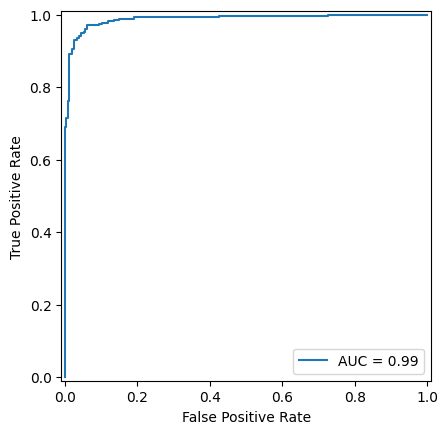

In [ ]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

Из той же документации следует, что еще можно использовать confidence values, которые можно получить из обученного классификатора при помощи метода decision_function:

In [ ]:
# The confidence score for a sample is proportional to the signed distance of that sample to the hyperplane. (документация)
confidence_values = classifier.decision_function(X_test_binary)

In [ ]:
fpr1, tpr1, thresholds1 = roc_curve(y_test_binary, confidence_values)
roc_auc1 = auc(fpr1, tpr1)

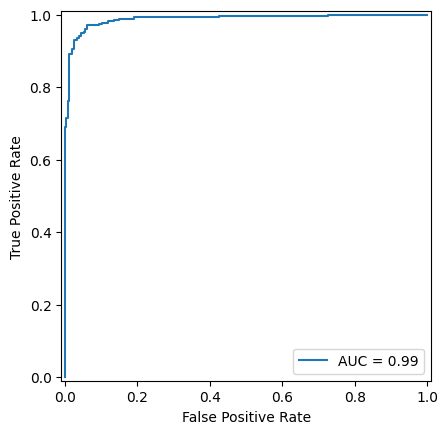

In [ ]:
display1 = RocCurveDisplay(fpr=fpr1, tpr=tpr1, roc_auc=roc_auc1)
display1.plot()

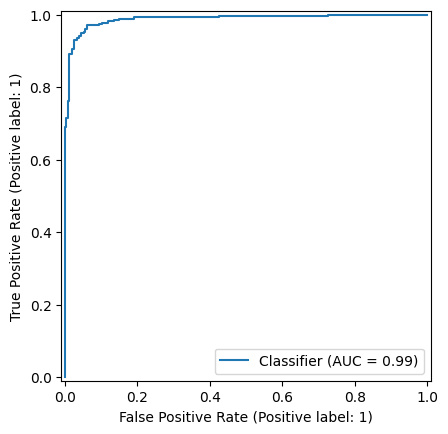

In [ ]:
RocCurveDisplay.from_predictions(y_test_binary, predicted_probs[:,1])

## Что еще можно узнать с помощью логистической регрессии

Из модели можно достать коэффициенты, чтобы узнать, какие признаки больше всего влияют на выбор того или иного класса.

Наши признаки - это токены. Упорядоченные признаки из векторайзера можно получить при помощи метода get_feature_names_out(). Именно в таком порядке признаки расположены в матрице, которая передается в модель.

In [ ]:
feature_names = tf_idf.get_feature_names_out()

In [ ]:
feature_names.shape

(19337,)

Можно заметить, что число коэффициентов модели равно числу признаков:

In [ ]:
classifier.coef_.shape

(1, 19337)

In [ ]:
classifier.coef_

array([[ 0.013128  , -0.61860597, -0.28888207, ...,  0.20896879,
         0.10314237,  0.10314237]])

In [ ]:
classifier.coef_[0, 1112]

0.10718042499299534

In [ ]:
feature_names[1112]

'adventures'

Создадим датафрейм для удобства (код отсюда: https://programminghistorian.org/en/lessons/logistic-regression)

In [ ]:
features_df_binary = pd.DataFrame()
features_df_binary['term'] = feature_names
features_df_binary['coef'] = classifier.coef_[0]

coefficients_binary = features_df_binary.sort_values(by='coef', ascending=False).reset_index(drop=True)

Признаки, более всего ассоциированные с позитивным классом "1" (у нас это 'Positive'), будут вверху уподяроченной таблицы:

In [ ]:
coefficients_binary[:25]

,term,coef
0,love,8.197333
1,best,6.682930
2,excited,6.090526
3,fun,5.981009
4,thank,5.803700
5,amazing,5.392120
6,wait,5.314504
7,cool,5.065158
8,great,4.919382
9,thanks,4.894295


"Не-позитивные" признаки же будут внизу:

In [ ]:
coefficients_binary[-25:]

,term,coef
19312,servers,-3.306206
19313,rainbow6game,-3.333121
19314,bad,-3.337888
19315,dirty,-3.357838
19316,wtf,-3.408023
19317,bullshit,-3.415002
19318,madden,-3.421650
19319,sad,-3.566459
19320,lost,-3.592881
19321,broken,-3.725157


Кажется, что всё распределилось вполне логично!

## Что, если классов всё-таки больше двух?

In [ ]:
le_multi = LabelEncoder()

In [ ]:
le_multi.fit(train['sentiment'])

LabelEncoder()

In [ ]:
le_multi.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [ ]:
y_train = le_multi.transform(train['sentiment'])
y_test = le_multi.transform(test['sentiment'])

In [ ]:
tf_idf_multi = TfidfVectorizer()

In [ ]:
tf_idf_multi.fit(train['tweet'])

TfidfVectorizer()

In [ ]:
X_train = tf_idf_multi.transform(train['tweet'])
X_test = tf_idf_multi.transform(test['tweet'])

Начнем опять с байесовского классификатора.

In [ ]:
nb_multi = MultinomialNB()

In [ ]:
nb_multi.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_test_pred_nb_multi = nb_multi.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred_nb_multi, target_names=le_multi.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.98      0.60      0.74       172
    Negative       0.70      0.94      0.80       266
     Neutral       0.91      0.70      0.79       285
    Positive       0.78      0.89      0.83       277

    accuracy                           0.80      1000
   macro avg       0.84      0.78      0.79      1000
weighted avg       0.83      0.80      0.80      1000



Уже не так хорошо, как в прошлый раз. Попробуем снова логрег.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

In [ ]:
# one-vs-the-rest-сеттинг позволяет сравнивать каждый класс со всеми остальными
# таким образом, коэффициенты будут осмысленными
# если коэффициенты вас не интересуют, а интересует только качество классификации, воспользуйтесь следующим синтаксисом:
#clf_multi = LogisticRegression(max_iter=1000, random_state=42, multi_class="multinomial", class_weight='balanced')
clf_multi = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))

In [ ]:
clf_multi.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                 max_iter=1000,
                                                 random_state=42))

In [ ]:
y_test_pred = clf_multi.predict(X_test)

In [ ]:
print(classification_report(y_test, y_test_pred, target_names=le_multi.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.88      0.89      0.89       172
    Negative       0.90      0.91      0.91       266
     Neutral       0.91      0.89      0.90       285
    Positive       0.90      0.90      0.90       277

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



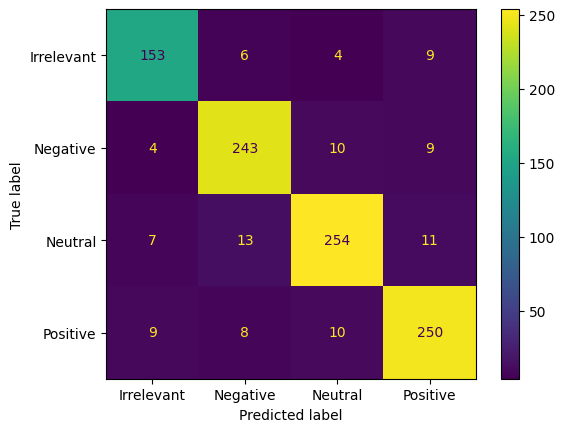

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm, display_labels=le_multi.classes_).plot()

Кривую ошибок мы будем создавать для каждого класса отдельно. Сразу сделаем вероятности классов на тестовой выборке:

In [ ]:
predicted_probs_multi = clf_multi.predict_proba(X_test)

Классов 4, поэтому и вероятностей 4 для каждого твита:

In [ ]:
predicted_probs_multi.shape

(1000, 4)

In [ ]:
predicted_probs_multi

array([[0.56763779, 0.17050259, 0.20295455, 0.05890508],
       [0.00763997, 0.17793587, 0.71162719, 0.10279698],
       [0.12195128, 0.58275189, 0.18387679, 0.11142004],
       ...,
       [0.12621348, 0.07308764, 0.17016281, 0.63053608],
       [0.08523024, 0.0963162 , 0.20444565, 0.6140079 ],
       [0.00282359, 0.07715243, 0.89235473, 0.02766924]])

Здесь и далее в части про кривые ошибок код отсюда: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc

Нам нужно не просто закодировать, а бинаризовать лейблы, т.е. сделать их состоящими только из нулей и единиц. Для этого есть класс LabelBinarizer:

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

In [ ]:
y_onehot_test.shape

(1000, 4)

Здесь, например, первый пример принадлежит "нерелевантному" классу, второй - "нейтральному", третий и четвёртый - "негативному". (Если вы забыли, в каком порядке идут классы, вызовите le_multi.classes_)

In [ ]:
y_onehot_test[:4]

array([[1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]])

In [ ]:
le_multi.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

Посмотрим на ROC-кривую для позитивного класса.

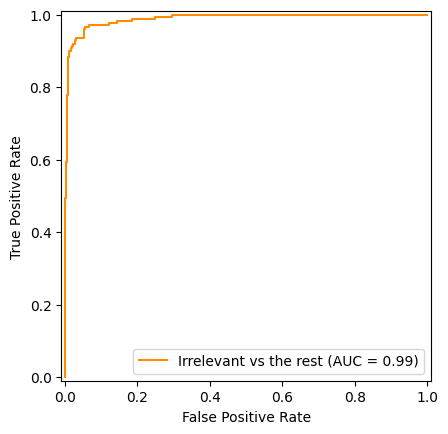

In [ ]:
class_id = 0
class_of_interest = "Irrelevant"

display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    predicted_probs_multi[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate"
)

Посмотрим на коэффициенты для каждого класса:

In [ ]:
clf_multi.estimators_

[LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)]

In [ ]:
clf_multi.classes_

array([0, 1, 2, 3])

In [ ]:
# не забываем, что мы меняли векторайзер
feature_names_multi = tf_idf_multi.get_feature_names_out()

In [ ]:
features_df = pd.DataFrame()
features_df['term'] = feature_names_multi
features_df['coef_Irrelevant'] = clf_multi.estimators_[0].coef_[0]
features_df['coef_Negative'] = clf_multi.estimators_[1].coef_[0]
features_df['coef_Neutral'] = clf_multi.estimators_[2].coef_[0]
features_df['coef_Positive'] = clf_multi.estimators_[3].coef_[0]

Так как мы оперировали в one-vs-the-rest условиях, при выборе позитивного класса сверху таблицы у нас будут находиться "позитивные" слова, а снизу - все "не позитивные". Поэтому значение для нас сейчас имеет только верх таблицы.

In [ ]:
coefficients_pos = features_df.sort_values(by='coef_Positive', ascending=False).reset_index(drop=True)

In [ ]:
coefficients_pos[:25]

,term,coef_Irrelevant,coef_Negative,coef_Neutral,coef_Positive
0,love,-0.126251,-6.256365,-2.021114,5.498107
1,wait,-2.011716,-3.692613,-2.914969,5.397499
2,fun,-2.079655,-4.276621,-2.263941,5.366106
3,excited,-0.698604,-5.009772,-3.219118,5.057649
4,thank,-1.347801,-4.391340,-1.796063,4.831401
5,pic,-1.575494,1.053568,-2.596529,4.752530
6,dope,0.039628,-3.897797,-2.537513,4.280374
7,best,1.171397,-5.441760,-2.342273,4.240017
8,amazing,-0.347828,-4.073890,-2.181222,4.217784
9,nice,-0.839056,-2.920119,-3.259683,4.170726


Какие слова выйдут наверх для остальных классов?